In [84]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.linalg

In [85]:
def outer(A,B):
    return scipy.linalg.blas.dger(1.,A,B)

def MatrixMul(A,B):
    try:
        scipy.linalg.blas
    except AttributeError:
        return np.dot(A, B)
    
    if not A.flags['F_CONTIGUOUS']:
        AA = A.T
        transA = True
    else:
        AA = A
        transA = False
        
    if not B.flags['F_CONTIGUOUS']:
        BB = B.T
        transB = True
    else:
        BB = B
        transB = False
        
    return scipy.linalg.blas.dgemm(alpha=1., a=AA, b=BB, trans_a=transA, trans_b=transB)

def invert_chol(A):
    B, info = scipy.linalg.lapack.dpotrf(A)
    if info != 0: 
        print('Matrix is singular!')
        return
    inv, info = scipy.linalg.lapack.dpotri(B)
    if info != 0 :
        print('Inversion failed')
        return 
    inv[:,:] = inv[:,:] + np.transpose(np.triu(inv[:,:],1))
    return inv

def invert_LU(A):
    B, pivot, info = scipy.linalg.lapack.dgetrf(A)
    if info != 0: 
        print('Matrix is singular!')
        return
    inv, info = scipy.linalg.lapack.dgetri(B,pivot)
    if info != 0 :
        print('Inversion failed')
        return 
    return inv

In [86]:
def log_prob(x, mu, cov):
    diff = x - mu
    #return -0.5 * MatrixMul(np.transpose(diff), MatrixMul(invert_chol(cov), diff))
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

$$
P \propto e^{-\frac{1}{2}((\vec{x}-\vec{\mu})^TC^{-1}(\vec{x}-\vec{\mu}))}
$$

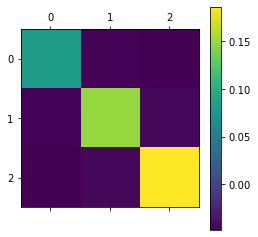

In [87]:
ndim = 3

#np.random.seed(12345)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = MatrixMul(cov, cov)

plt.matshow(cov)
plt.colorbar()

In [88]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

In [89]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

In [90]:
state = sampler.run_mcmc(p0, 100)

In [91]:
sampler.reset()
sampler.run_mcmc(state, 10000);

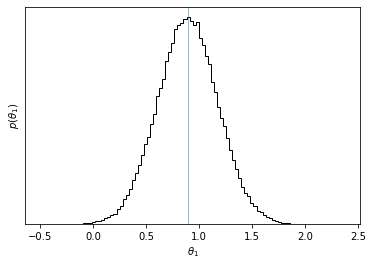

In [92]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.axvline(means[0],lw=0.5)
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

$$
P(\theta_1,\theta_2,\theta_3,\theta_4)
$$
$$
P(\theta_1) = \int P(\theta_1,\theta_2,\theta_3,\theta_4)d\theta_2d\theta_3d\theta_4
$$

$$
\langle\theta_1\rangle = \int\theta_1P(\theta_1)d\theta_1
$$
$$
\langle(\theta_1-\mu)^2\rangle = \int(\theta_1-\mu)^2P(\theta_1)d\theta_1
$$
$$
\bar{\theta_1} = \frac{1}{N-1}\Sigma^N_i\theta_1^i
$$

In [95]:
post, edges = np.histogram(samples[:,0]) #non è la vera P(theta1)

In [96]:
mean_1 = np.mean(samples[:,0])

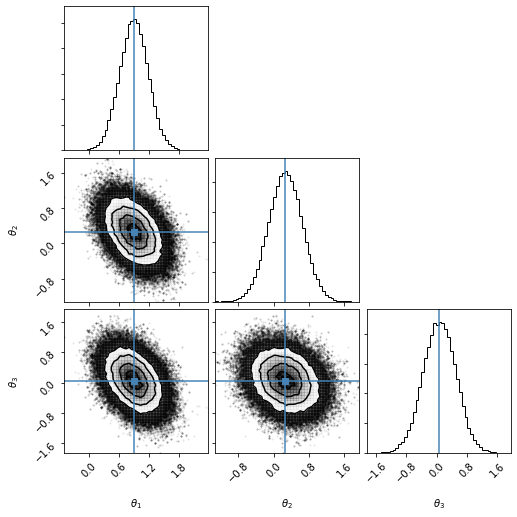

In [97]:
import corner
figure = corner.corner(samples,bins=50,labels=[r'$\theta_1$',r'$\theta_2$',r'$\theta_3$'],truths=means)

Text(0, 0.5, 'P')

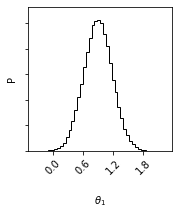

In [112]:
figure = corner.corner(samples[:,0],bins=50,labels=[r'$\theta_1$'])
plt.ylabel('P')

conda install -c conda-forge corner